In [1]:
!pip install statsmodels==0.14.4

DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import scipy.stats as stat
from sklearn.metrics import roc_curve, roc_auc_score
import pickle
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stat
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


warnings.filterwarnings('ignore')

In [3]:
df = pd.read_parquet('/home/noise/Documentos/credit_risk/data/clean_loan_data (1).parquet')

In [4]:
df_defaults = df.loc[(df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off') |
                    (df['loan_status'] == 'Charged Off')]

In [5]:
df_defaults['recovery_rate'].head()


3     0.000036
4     0.134198
11    0.007650
14    0.037262
15    0.000000
Name: recovery_rate, dtype: float32

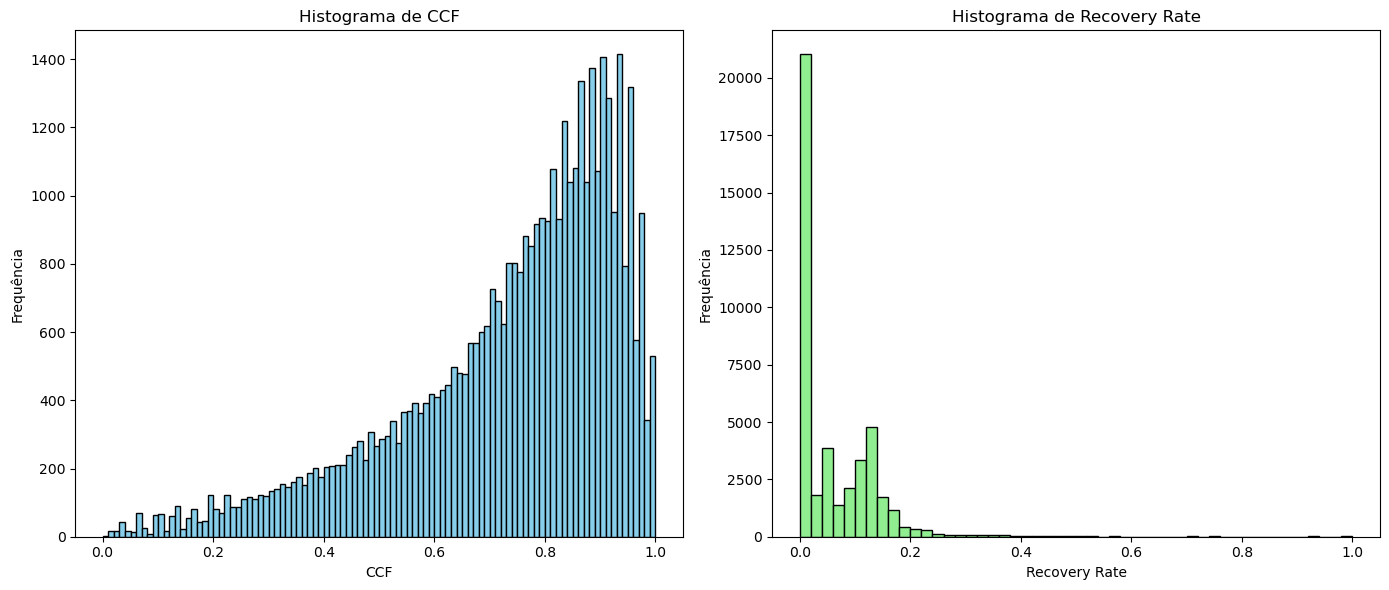

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histograma para 'CCF'
axs[0].hist(df_defaults['credit_conversion_factor'], bins=100, color='skyblue', edgecolor='black')
axs[0].set_title('Histograma de CCF')
axs[0].set_xlabel('CCF')
axs[0].set_ylabel('Frequência')

# Histograma para 'recoveri_rate'
axs[1].hist(df_defaults['recovery_rate'], bins=50, color='lightgreen', edgecolor='black')
axs[1].set_title('Histograma de Recovery Rate')
axs[1].set_xlabel('Recovery Rate')
axs[1].set_ylabel('Frequência')

plt.tight_layout()

# Mostrar os gráficos
plt.show()

Os valores da taxa de recuperação estão, em sua maioria, concentrados em 0. Dessa forma, seria interessante utilizar um modelo de regressão logística para prever se o valor é 0 ou maior que 0. Caso seja maior que 0, aplicaríamos uma regressão linear para estimar o valor exato.

Além disso, o Fator de Conversão de Crédito (CCF) apresenta uma distribuição normal assimétrica à esquerda.

Fator de Conversão de Crédito (CCF), que estima a proporção do montante não utilizado que será sacado antes do default.

Se o fator de conversão for 50%, significa que, em média, os clientes usam 50% do que ainda têm disponível antes de darem o calote.

In [7]:
df_defaults['recoveri_rate_>0'] = np.where(df_defaults['recovery_rate'] == 0, 0, 1)
df_defaults['recoveri_rate_>0'].value_counts()

recoveri_rate_>0
1    24368
0    18865
Name: count, dtype: int64

In [8]:
train, test = np.split(df_defaults, [int(.80 * len(df_defaults))])
train['set'] = 'train'
test['set'] = 'test'

print(train.shape[0])
print(test.shape[0])

34586
8647


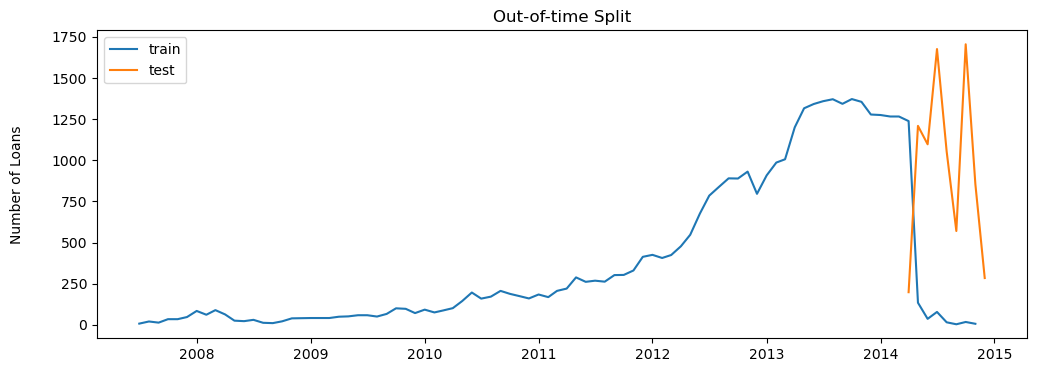

In [9]:
train_test = pd.concat([train, test])
train_test = train_test.groupby(['issue_d', 'set'])['default'].count().reset_index().rename(columns={'default': 'loans'})

fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Out-of-time Split')
sns.lineplot(train_test, x='issue_d', y='loans', hue='set', ax=ax)
plt.xlabel('')
plt.ylabel('Number of Loans', labelpad=20)
plt.grid(False)
plt.legend(loc='upper left')
plt.show()

# Drop columns used only for plotting.
to_drop = ['issue_d', 'set']
train = train.drop(columns=to_drop)
test = test.drop(columns=to_drop)

In [10]:
state_to_region = {
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast', 'MA': 'Northeast', 'RI': 'Northeast', 'CT': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast',
    'OH': 'Midwest', 'MI': 'Midwest', 'IN': 'Midwest', 'IL': 'Midwest', 'WI': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest',
    'DE': 'South', 'MD': 'South', 'VA': 'South', 'WV': 'South', 'KY': 'South', 'NC': 'South', 'SC': 'South', 'TN': 'South', 'GA': 'South', 'FL': 'South', 'AL': 'South', 'MS': 'South', 'AR': 'South', 'LA': 'South', 'TX': 'South', 'OK': 'South',
    'MT': 'West', 'ID': 'West', 'WY': 'West', 'CO': 'West', 'NM': 'West', 'AZ': 'West', 'UT': 'West', 'NV': 'West', 'WA': 'West', 'OR': 'West', 'CA': 'West', 'AK': 'West', 'HI': 'West', 'DC': 'Northeast',
}


train['region'] = train['addr_state'].replace(state_to_region)
test['region'] = test['addr_state'].replace(state_to_region)

train['home_ownership'] = train['home_ownership'].replace(['RENT', 'NONE', 'OTHER'], 'RENT_NONE_OTHER')
test['home_ownership'] = test['home_ownership'].replace(['RENT', 'NONE', 'OTHER'], 'RENT_NONE_OTHER')
train['purpose'] = train['purpose'].replace(['educational', 'renewable_energy'], 'other')
test['purpose'] = test['purpose'].replace(['educational', 'renewable_energy'], 'other')
train['purpose'] = train['purpose'].replace(['vacation', 'moving', 'wedding'], 'vacation_moving_wedding')
test['purpose'] = test['purpose'].replace(['vacation', 'moving', 'wedding'], 'vacation_moving_wedding')
train['purpose'] = train['purpose'].replace(['house', 'car', 'medical'], 'house_car_medical')
test['purpose'] = test['purpose'].replace(['house', 'car', 'medical'], 'house_car_medical')

train['mths_since_last_delinq'] = train['mths_since_last_delinq'].fillna(0)
test['mths_since_last_delinq'] = test['mths_since_last_delinq'].fillna(0)

In [11]:
data_leakage_variables = ['funded_amnt', 'installment', 'revol_util', 
                         'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 
                         'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                         'last_pymnt_amnt', 'collections_12_mths_ex_med', 'tot_coll_amt']
irrelevant_variables = ['delinq_2yrs', 'acc_now_delinq', 'pub_rec', 
                        'total_rev_hi_lim', 'loan_status', 'default', 'addr_state']
to_drop = data_leakage_variables + irrelevant_variables


In [12]:
target_lgd_logistic = 'recoveri_rate_>0'
target_lgd_linear = 'recovery_rate'
target_ead = 'credit_conversion_factor'

targets = [target_lgd_logistic,target_lgd_linear, target_ead]
X_train = train.drop(columns=to_drop + targets)
X_test = test.drop(columns=to_drop + targets)
y_train_lgd_logistic = train[target_lgd_logistic].copy()
y_test_lgd_logistic = test[target_lgd_logistic].copy()
y_train_ead = train[target_ead].copy()
y_test_ead = test[target_ead].copy()


X_train_lgd_linear = train.loc[train['recoveri_rate_>0'] == 1].drop(columns=to_drop + targets)
X_test_lgd_linear = test.loc[test['recoveri_rate_>0'] == 1].drop(columns=to_drop + targets)
y_train_lgd_linear = train.loc[train['recoveri_rate_>0'] == 1, target_lgd_linear].copy()
y_test_lgd_linear = test.loc[test['recoveri_rate_>0'] == 1, target_lgd_linear].copy()




Ao realizar análises preditivas, buscamos melhorar a qualidade dos dados e otimizar a representatividade das variáveis. Duas abordagens estatísticas essenciais para esse processo são:

O teste de independência do Chi², que mede a relação entre variáveis categóricas.

O peso das evidências (WOE), que mede a capacidade discriminativa das variáveis na predição de um evento.

O uso conjunto dessas técnicas permite agrupar variáveis com comportamento semelhante, reduzindo a esparsidade do dataset e tornando-o mais eficiente para modelagem.

<img src="image-20250207-084315-20250207-114322.png" width="" align="" />

<img src="image-20250207-084402.png" width="" align="" />

<img src="image-20250207-084420.png" width="" align="" />

In [13]:
variables_categorical = X_train.select_dtypes('category').columns.tolist()
numerical_variables = X_train.select_dtypes('number').columns.tolist()

variables_categorical.append('term')
numerical_variables.remove('term')

print(f'Categorical features: {variables_categorical}')
print(f'Numerical features: {numerical_variables}')


Categorical features: ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'region', 'term']
Numerical features: ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'revol_bal', 'total_acc', 'tot_cur_bal', 'mths_since_earliest_cr_line']


In [14]:
nominal_features = ['term', 'region', 'home_ownership', 'purpose', 'verification_status', 'initial_list_status']
ordinal_features = ['grade', 'sub_grade']

nominal_pipe = Pipeline([
    ('one_hot_encoding', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

ordinal_pipe = Pipeline([
    ('ordinal_encoding', OrdinalEncoder()),  # Adicionada a vírgula aqui
    ('standard_scaling', StandardScaler())
])

numerical_pipe = Pipeline([
    ('median_imputing', SimpleImputer(strategy='median')),
    ('standard_scaling', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('numerical_pipeline', numerical_pipe, numerical_variables),
    ('nominal_pipeline', nominal_pipe, nominal_features),
    ('ordinal_pipeline', ordinal_pipe, ordinal_features)
], remainder='passthrough')

In [17]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

X_train_prepared_lgd_linear = preprocessor.fit_transform(X_train_lgd_linear)
X_test_prepared_lgd_linear = preprocessor.transform(X_test_lgd_linear)

feature_list =  ['_'.join(x.split('_')[3:]) for x in preprocessor.get_feature_names_out().tolist()]

X_train_prepared = pd.DataFrame(X_train_prepared, columns=feature_list)
X_test_prepared = pd.DataFrame(X_test_prepared, columns=feature_list)

X_train_prepared_lgd_linear = pd.DataFrame(X_train_prepared_lgd_linear, columns=feature_list)
X_test_prepared_lgd_linear = pd.DataFrame(X_test_prepared_lgd_linear, columns=feature_list)

with open('preprocessor_pipeline.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

In [16]:
X_train_prep

NameError: name 'X_train_prep' is not defined

> tire bloqueio de coluna e linha pandas

In [ ]:
class LogisticRegressionWithPvalues:
    '''
    Custom logistic regression class with p-values for coefficient significance.

    Attributes:
    alpha (float): Regularization parameter. Default is 0.
    method (str): Regularization method. Default is 'l1'.
    model: Fitted logistic regression model.

    Methods:
    __init__(alpha=0, method='l1'):
        Initializes the LogisticRegressionWithPvalues instance.

        Parameters:
        - alpha (float): Regularization parameter. Default is 0.
        - method (str): Regularization method ('l1'). Default is 'l1'.

    fit(X, y):
        Fit the regularized logistic regression model.

        Parameters:
        - X (DataFrame): Input features for model fitting.
        - y (array-like): Target variable for model fitting.

        Raises:
        - CustomException: If an exception occurs during fitting.

    predict(X):
        Predict probabilities using the fitted model.

        Parameters:
        - X (DataFrame): Input features for prediction.

        Returns:
        - predicted_probabilities: Predicted probabilities.

        Raises:
        - CustomException: If an exception occurs during prediction.

    get_result_table():
        Get a summary table with beta coefficients, p-values, and Wald statistics.

        Returns:
        - result: Summary table with Beta Coefficient, P-Value, and Wald Statistic.

        Raises:
        - CustomException: If an exception occurs during result table creation.
    '''
    def __init__(self, alpha=0, method='l1'):
        self.alpha = alpha
        self.method = method
        self.model = None

    def fit(self, X, y):
            # Add a constant to the data, which will be the intercept, and reshape y.
            X_copy = X.copy()
            X_copy = sm.add_constant(X_copy)
            y_reshaped = y.values.reshape(-1,1)

            # Fit the regularized logistic regression model.
            self.model = sm.Logit(y_reshaped, X_copy).fit_regularized(alpha=self.alpha, method=self.method)
        

    def predict(self, X):
            # Add a constant to the data, which will multiply the intercept.
            X_copy = X.copy()
            X_copy = sm.add_constant(X_copy)
            
            # Predicting probabilities.
            predicted_probabilities = self.model.predict(X_copy)
            
            return predicted_probabilities
        
    
    def get_summary_table(self):
        
            # Collect beta coefficients, p-values and Wald statistics in a summary table.
            summary = self.model.summary2().tables[1]
            summary['Wald'] = summary['z'] ** 2
            summary_table = summary[['Coef.', 'P>|z|', 'Wald']]
            summary_table.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
            summary_table = summary_table.sort_index()   
            return summary_table
        
        
        

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
lgd_logistic =  LogisticRegressionWithPvalues()
lgd_logistic.fit(X_train_prepared, y_train_lgd_logistic)
lgd_logistic.get_summary_table()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6340059717066088
            Iterations: 109
            Function evaluations: 109
            Gradient evaluations: 109


,Beta Coefficient,P-Value,Wald Statistic
annual_inc,0.080816,1.237907e-06,23.517377
const,0.408539,1.119583e-19,82.385745
dti,-0.099608,1.139652e-13,55.110076
emp_length,-0.014966,2.057642e-01,1.600981
grade,0.110210,5.118466e-02,3.802220
home_ownership_OWN,0.083074,6.161554e-02,3.493356
home_ownership_RENT_NONE_OTHER,0.067290,1.959049e-02,5.448023
initial_list_status_w,-0.927471,3.023354e-222,1012.761059
inq_last_6mths,0.008661,4.841412e-01,0.489521
int_rate,-0.066036,1.014715e-01,2.682262


In [ ]:
import os
import mlflow
from mlflow.models import infer_signature

# Configuração das credenciais e endpoints
os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'password'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9005'

# Configurar o URI do tracking do MLflow
mlflow.set_tracking_uri("http://localhost:5001")

# Criar a assinatura do modelo
signature = infer_signature(X_train_prepared, lgd_logistic.predict(X_train_prepared))

try:
    with mlflow.start_run():
        # Preparar exemplo de input
        processed_input_example = X_train_prepared.head(1)

        # Registrar o modelo
        mlflow.sklearn.log_model(
            sk_model=lgd_logistic.model,
            artifact_path="model",
            signature=signature,
            input_example=processed_input_example
        )
        
        # Registrar o summary
        summary_table = lgd_logistic.get_summary_table()
        
        # Salvar e registrar o summary como artifact
        summary_path = "summary_table.csv"
        summary_table.to_csv(summary_path, index=False)
        mlflow.log_artifact(summary_path)
        
        print("Modelo e artefatos registrados com sucesso no MLflow")

except Exception as e:
    print(f"Erro durante o registro no MLflow: {str(e)}")
    raise

2025/03/01 19:13:03 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "loan_amnt",
      "int_rate",
      "emp_length",
      "annual_inc",
      "dti",
      "inq_last_6mths",
      "mths_since_last_delinq",
      "open_acc",
      "revol_bal",
      "total_acc",
      "tot_cur_bal",
      "mths_since_earliest_cr_line",
      "term_60",
      "region_Northeast",
      "region_South",
      "region_West",
      "home_ownership_OWN",
      "home_ownership_RENT_NONE_OTHER",
      "purpose_debt_consolidation",
      "purpose_home_improvement",
      "purpose_house_car_medical",
      "purpose_major_purchase",
      "purpose_other",
      "purpose_small_business",
      "purpose_vacation_moving_wedding",
      "verification_status_Source Verified",
      "verification_status_Verified",
      "initial_list_status_w",
      "grade",
      "sub_grade"
    ],
    "data": [
      [
        -0.8748195172299768,
        0.050532

Modelo e artefatos registrados com sucesso no MLflow


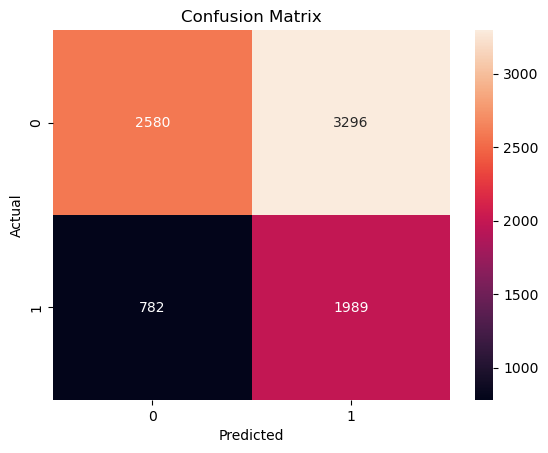

In [ ]:
lgd_prob = lgd_logistic.predict(X_test_prepared)
tresh = 0.48
lgd_prep = np.where(lgd_prob >= tresh, 1, 0)

cm = confusion_matrix(y_test_lgd_logistic, lgd_prep)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

A matriz de confusão é uma ferramenta fundamental na avaliação do desempenho de modelos de classificação. Ela fornece uma visão detalhada de quantas instâncias de cada classe foram corretamente ou incorretamente classificadas pelo modelo. Em outras palavras, ela compara as classes reais (verdadeiras) com as classes que o modelo previu.

Estrutura da Matriz de Confusão
Em um problema de classificação binária (duas classes, por exemplo, “Positivo” e “Negativo”), a matriz de confusão é geralmente organizada da seguinte forma:



<img src="image-20250207-200131.png" width="" align="" />

<img src="image-20250207-200246.png" width="" align="" />

In [ ]:
X_train_lgd_linear_const = sm.add_constant(X_train_prepared_lgd_linear)
y_train_lgd_linear_reshape = y_train_lgd_linear.values.reshape(-1,1)
lgd_linear = sm.OLS(y_train_lgd_linear_reshape, X_train_lgd_linear_const).fit()

In [ ]:
import os
import mlflow
import statsmodels.api as sm
import pandas as pd
import numpy as np
from mlflow.models import infer_signature

# Configuração das credenciais e endpoints
os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'password'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9005'

# Configurar o URI do tracking do MLflow
mlflow.set_tracking_uri("http://localhost:5001")

# Salvar as colunas originais e com constante para uso na predição
original_columns = X_train_prepared_lgd_linear.columns.tolist()
columns_with_const = X_train_lgd_linear_const.columns.tolist()

# Criar a assinatura do modelo
X_test_prepared = X_train_prepared_lgd_linear.copy()  # Usando os dados de treino como exemplo
X_test_const = sm.add_constant(X_test_prepared)
predictions = lgd_linear.predict(X_test_const)
signature = infer_signature(X_train_prepared_lgd_linear, predictions)

try:
    with mlflow.start_run():
        # Preparar exemplo de input
        processed_input_example = X_train_prepared_lgd_linear.head(1)
        
        # Registrar parâmetros
        mlflow.log_param("num_variables", len(lgd_linear.params))
        mlflow.log_param("r_squared", lgd_linear.rsquared)
        mlflow.log_param("adjusted_r_squared", lgd_linear.rsquared_adj)
        
        # Registrar o sumário do modelo como tabela
        summary_df = pd.DataFrame({
            'variable': lgd_linear.model.exog_names,
            'coefficient': lgd_linear.params,
            'std_err': lgd_linear.bse,
            't_value': lgd_linear.tvalues,
            'p_value': lgd_linear.pvalues,
            'conf_int_lower': lgd_linear.conf_int()[0],
            'conf_int_upper': lgd_linear.conf_int()[1]
        })
        
        # Salvar e registrar o summary como artifact
        summary_path = "summary_table.csv"
        summary_df.to_csv(summary_path, index=False)
        mlflow.log_artifact(summary_path)
        
        # Registrar métricas adicionais
        mlflow.log_metric("aic", lgd_linear.aic)
        mlflow.log_metric("bic", lgd_linear.bic)
        mlflow.log_metric("fvalue", lgd_linear.fvalue)
        
        # Para modelos statsmodels, podemos usar o log_model do pyfunc
        # Criamos um wrapper para o modelo com tratamento correto das colunas
        class OLSWrapper(mlflow.pyfunc.PythonModel):
            def __init__(self, model, original_columns, columns_with_const):
                self.model = model
                self.original_columns = original_columns
                self.columns_with_const = columns_with_const
                
            def predict(self, context, X):
                # Verificar se X é um DataFrame, caso contrário, converter
                if not isinstance(X, pd.DataFrame):
                    X = pd.DataFrame(X, columns=self.original_columns)
                
                # Adicionar a constante
                X_with_const = sm.add_constant(X)
                
                # Garantir que as colunas estão na mesma ordem do treinamento
                if set(X_with_const.columns) != set(self.columns_with_const):
                    # Se alguma coluna estiver faltando (além da constante), é um erro
                    missing_cols = set(self.columns_with_const) - set(X_with_const.columns) - {'const'}
                    if missing_cols:
                        raise ValueError(f"Colunas ausentes: {missing_cols}")
                
                # Reorganizar na mesma ordem usada no treinamento
                X_with_const = X_with_const[self.columns_with_const]
                
                return self.model.predict(X_with_const)
        
        # Salvar o modelo OLS com o wrapper corrigido
        mlflow.pyfunc.log_model(
            artifact_path="model",
            python_model=OLSWrapper(lgd_linear, original_columns, columns_with_const),
            signature=signature,
            input_example=processed_input_example
        )
        
        # Salvar o resultado do summary como texto
        summary_txt_path = "model_summary.txt"
        with open(summary_txt_path, "w") as f:
            f.write(str(lgd_linear.summary()))
        mlflow.log_artifact(summary_txt_path)
        
        print("Modelo OLS e artefatos registrados com sucesso no MLflow")

except Exception as e:
    print(f"Erro durante o registro no MLflow: {str(e)}")
    raise

2025/03/01 19:13:14 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
KeyError("['const'] not in index")Traceback (most recent call last):


  File "/home/noise/anaconda3/lib/python3.11/site-packages/mlflow/utils/_capture_modules.py", line 166, in load_model_and_predict
    model.predict(input_example, params=params)


  File "/home/noise/anaconda3/lib/python3.11/site-packages/mlflow/pyfunc/model.py", line 642, in predict
    return self.python_model.predict(self.context, self._convert_input(model_input))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  File "/tmp/ipykernel_324303/3477106552.py", line 81, in predict


  File "/home/noise/anaconda3/lib/python3.11/site-packages/pandas/core/frame.py", line 3899, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  File "/ho

2025/03/01 19:13:16 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "loan_amnt",
      "int_rate",
      "emp_length",
      "annual_inc",
      "dti",
      "inq_last_6mths",
      "mths_since_last_delinq",
      "open_acc",
      "revol_bal",
      "total_acc",
      "tot_cur_bal",
      "mths_since_earliest_cr_line",
      "term_60",
      "region_Northeast",
      "region_South",
      "region_West",
      "home_ownership_OWN",
      "home_ownership_RENT_NONE_OTHER",
      "purpose_debt_consolidation",
      "purpose_home_improvement",
      "purpose_house_car_medical",
      "purpose_major_purchase",
      "purpose_other",
      "purpose_small_business",
      "purpose_vacation_moving_wedding",
      "verification_status_Source Verified",
      "verification_status_Verified",
      "initial_list_status_w",
      "grade",
      "sub_grade"
    ],
    "data": [
      [
        -0.8812696265134561,
        0.006487

Modelo OLS e artefatos registrados com sucesso no MLflow


In [ ]:
lgd_prob

0       0.720574
1       0.465107
2       0.292320
3       0.424422
4       0.726285
5       0.481639
6       0.597342
7       0.470479
8       0.359447
9       0.439900
10      0.635297
11      0.419739
12      0.290946
13      0.480639
14      0.704821
15      0.631467
16      0.427408
17      0.415406
18      0.440768
19      0.450529
20      0.326182
21      0.666133
22      0.555683
23      0.705969
24      0.406546
25      0.499551
26      0.428704
27      0.292164
28      0.660238
29      0.508688
30      0.404765
31      0.356272
32      0.696558
33      0.338110
34      0.515638
35      0.645086
36      0.549124
37      0.502834
38      0.655038
39      0.424547
40      0.454477
41      0.751973
42      0.652610
43      0.427034
44      0.390155
45      0.395635
46      0.623638
47      0.583729
48      0.692851
49      0.683301
50      0.494476
51      0.490874
52      0.561940
53      0.634356
54      0.442043
55      0.662307
56      0.707399
57      0.425819
58      0.6446

In [ ]:
lgd_linear.params.sort_values(ascending=False)

const                                  0.105800
int_rate                               0.026877
initial_list_status_w                  0.024560
purpose_vacation_moving_wedding        0.007458
home_ownership_OWN                     0.006662
total_acc                              0.006445
tot_cur_bal                            0.005463
term_60                                0.005312
annual_inc                             0.002920
mths_since_earliest_cr_line            0.002395
dti                                    0.002390
verification_status_Verified           0.001126
emp_length                             0.000988
verification_status_Source Verified    0.000818
home_ownership_RENT_NONE_OTHER         0.000591
mths_since_last_delinq                -0.000486
revol_bal                             -0.000796
inq_last_6mths                        -0.000836
purpose_other                         -0.001587
purpose_debt_consolidation            -0.001698
purpose_major_purchase                -0

Alguma interpretação: O coeficiente da taxa de juros é 0,026877. Isso implica que, para cada aumento de um ponto percentual na taxa de juros, há um aumento de aproximadamente 2,7 pontos percentuais na taxa de recuperação.

<img src="image-20250208-000653.png" width="" align="" />

In [ ]:
X_test_lgd_linear_const = sm.add_constant(X_test_prepared_lgd_linear)
lgd_linear_pred = lgd_linear.predict(X_test_lgd_linear_const)


lgd_linear.params.sort_values(ascending=False)

const                                  0.105800
int_rate                               0.026877
initial_list_status_w                  0.024560
purpose_vacation_moving_wedding        0.007458
home_ownership_OWN                     0.006662
total_acc                              0.006445
tot_cur_bal                            0.005463
term_60                                0.005312
annual_inc                             0.002920
mths_since_earliest_cr_line            0.002395
dti                                    0.002390
verification_status_Verified           0.001126
emp_length                             0.000988
verification_status_Source Verified    0.000818
home_ownership_RENT_NONE_OTHER         0.000591
mths_since_last_delinq                -0.000486
revol_bal                             -0.000796
inq_last_6mths                        -0.000836
purpose_other                         -0.001587
purpose_debt_consolidation            -0.001698
purpose_major_purchase                -0

In [ ]:
lgd_linear_pred_all = lgd_linear.predict(X_test_lgd_linear_const)
lgd_linear_pred_all_aligned = pd.Series(lgd_linear_pred_all, index=X_test_prepared_lgd_linear.index).reindex(X_test_prepared.index, fill_value=0)

lgd_pred = lgd_prep * lgd_linear_pred_all_aligned
lgd_pred.describe()

ValueError: operands could not be broadcast together with shapes (8647,) (21597,) 

In [ ]:
lgd_prep

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
X_train_prepared_ead = sm.add_constant(X_train_prepared)
y_train_reshape = y_train_ead.values.reshape(-1,1)
ead_linear = sm.OLS(y_train_reshape, X_train_prepared_ead).fit()

In [ ]:
import os
import mlflow
import statsmodels.api as sm
import pandas as pd
import numpy as np
from mlflow.models import infer_signature

# Configuração das credenciais e endpoints
os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'password'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9005'

# Configurar o URI do tracking do MLflow
mlflow.set_tracking_uri("http://localhost:5001")

# Salvar as colunas originais e com constante para uso na predição
original_columns = X_train_prepared.columns.tolist()
columns_with_const = X_train_prepared_ead.columns.tolist()

# Função para predição usando o modelo OLS
class OLSWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model, original_columns, columns_with_const):
        self.model = model
        self.original_columns = original_columns
        self.columns_with_const = columns_with_const
        
    def predict(self, context, X):
        # Verificar se X é um DataFrame, caso contrário, converter
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.original_columns)
        
        # Adicionar a constante mantendo a mesma ordem de colunas usada no treinamento
        X_with_const = sm.add_constant(X)
        
        # Garantir que as colunas estão na mesma ordem do treinamento
        if set(X_with_const.columns) != set(self.columns_with_const):
            # Se alguma coluna estiver faltando, precisamos ajustar
            for col in self.columns_with_const:
                if col not in X_with_const and col != 'const':
                    raise ValueError(f"Coluna {col} ausente nos dados de entrada")
        
        # Reorganizar na mesma ordem usada no treinamento
        X_with_const = X_with_const[self.columns_with_const]
        
        return self.model.predict(X_with_const)

# Criar a assinatura do modelo
X_example = X_train_prepared.copy()  # Usando os dados de treino como exemplo
X_example_const = sm.add_constant(X_example)
predictions = ead_linear.predict(X_example_const)
signature = infer_signature(X_train_prepared, predictions)

# Exemplo de entrada para o MLflow
processed_input_example = X_train_prepared.head(1)

try:
    with mlflow.start_run():
        # Registrar parâmetros
        mlflow.log_param("num_variables", len(ead_linear.params))
        mlflow.log_param("r_squared", ead_linear.rsquared)
        mlflow.log_param("adjusted_r_squared", ead_linear.rsquared_adj)
        
        # Registrar o sumário do modelo como tabela
        summary_df = pd.DataFrame({
            'variable': ead_linear.model.exog_names,
            'coefficient': ead_linear.params,
            'std_err': ead_linear.bse,
            't_value': ead_linear.tvalues,
            'p_value': ead_linear.pvalues,
            'conf_int_lower': ead_linear.conf_int()[0],
            'conf_int_upper': ead_linear.conf_int()[1]
        })
        
        # Salvar e registrar o summary como artifact
        summary_path = "ead_summary_table.csv"
        summary_df.to_csv(summary_path, index=False)
        mlflow.log_artifact(summary_path)
        
        # Registrar métricas adicionais
        mlflow.log_metric("aic", ead_linear.aic)
        mlflow.log_metric("bic", ead_linear.bic)
        mlflow.log_metric("fvalue", ead_linear.fvalue)
        
        # Salvar o modelo OLS usando o wrapper corrigido
        mlflow.pyfunc.log_model(
            artifact_path="model",
            python_model=OLSWrapper(ead_linear, original_columns, columns_with_const),
            signature=signature,
            input_example=processed_input_example
        )
        
        # Salvar o resultado do summary como texto
        summary_txt_path = "ead_model_summary.txt"
        with open(summary_txt_path, "w") as f:
            f.write(str(ead_linear.summary()))
        mlflow.log_artifact(summary_txt_path)
        
        print("Modelo EAD OLS e artefatos registrados com sucesso no MLflow")

except Exception as e:
    print(f"Erro durante o registro no MLflow: {str(e)}")
    raise

2025/03/01 19:14:43 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
KeyError("['const'] not in index")Traceback (most recent call last):


  File "/home/noise/anaconda3/lib/python3.11/site-packages/mlflow/utils/_capture_modules.py", line 166, in load_model_and_predict
    model.predict(input_example, params=params)


  File "/home/noise/anaconda3/lib/python3.11/site-packages/mlflow/pyfunc/model.py", line 642, in predict
    return self.python_model.predict(self.context, self._convert_input(model_input))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  File "/tmp/ipykernel_324303/1330538656.py", line 43, in predict


  File "/home/noise/anaconda3/lib/python3.11/site-packages/pandas/core/frame.py", line 3899, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  File "/ho

2025/03/01 19:14:49 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "loan_amnt",
      "int_rate",
      "emp_length",
      "annual_inc",
      "dti",
      "inq_last_6mths",
      "mths_since_last_delinq",
      "open_acc",
      "revol_bal",
      "total_acc",
      "tot_cur_bal",
      "mths_since_earliest_cr_line",
      "term_60",
      "region_Northeast",
      "region_South",
      "region_West",
      "home_ownership_OWN",
      "home_ownership_RENT_NONE_OTHER",
      "purpose_debt_consolidation",
      "purpose_home_improvement",
      "purpose_house_car_medical",
      "purpose_major_purchase",
      "purpose_other",
      "purpose_small_business",
      "purpose_vacation_moving_wedding",
      "verification_status_Source Verified",
      "verification_status_Verified",
      "initial_list_status_w",
      "grade",
      "sub_grade"
    ],
    "data": [
      [
        -0.8748195172299768,
        0.050532

Modelo EAD OLS e artefatos registrados com sucesso no MLflow


In [ ]:
ead_linear.params.sort_values(ascending=False)

const                                  0.635015
term_60                                0.120546
int_rate                               0.060655
initial_list_status_w                  0.035489
purpose_small_business                 0.026565
verification_status_Source Verified    0.026269
purpose_other                          0.018114
purpose_vacation_moving_wedding        0.016397
purpose_major_purchase                 0.015539
purpose_home_improvement               0.011907
inq_last_6mths                         0.010427
verification_status_Verified           0.009272
tot_cur_bal                            0.008850
home_ownership_OWN                     0.008794
total_acc                              0.008600
home_ownership_RENT_NONE_OTHER         0.007433
purpose_debt_consolidation             0.006959
dti                                    0.004529
loan_amnt                              0.002789
region_West                            0.000739
purpose_house_car_medical              0

In [ ]:
X_test_prepared_ead = sm.add_constant(X_test_prepared)
ead_linear_pred = ead_linear.predict(X_test_prepared_ead)

In [ ]:

# Iniciar uma corrida do MLflow
mlflow.start_run(run_name="statsmodels_ols_ead_model")

# Registrar parâmetros do modelo
params = {
    "method": ead_linear.method,
    "nobs": ead_linear.nobs,
    "df_model": ead_linear.df_model,
    "df_resid": ead_linear.df_resid
}
mlflow.log_params(params)

# Fazer predições e calcular métricas
X_test_prepared_ead = sm.add_constant(X_test_prepared)
y_pred = ead_linear.predict(X_test_prepared_ead)
y_test_ead_reshape = y_test_ead.values.reshape(-1,1)

# Registrar métricas
metrics = {
    "r_squared": ead_linear.rsquared,
    "adj_r_squared": ead_linear.rsquared_adj,
    "mse": mean_squared_error(y_test_ead_reshape, y_pred.reshape(-1,1)),
    "rmse": np.sqrt(mean_squared_error(y_test_ead_reshape, y_pred.reshape(-1,1))),
    "aic": ead_linear.aic,
    "bic": ead_linear.bic
}
mlflow.log_metrics(metrics)

# Salvar o sumário do modelo como artefato
summary_html = ead_linear.summary().as_html()
with open("ead_model_summary.html", "w") as f:
    f.write(summary_html)
mlflow.log_artifact("ead_model_summary.html")

# Salvar os coeficientes como CSV
coefs_df = pd.DataFrame({
    'feature': ead_linear.model.exog_names,
    'coefficient': ead_linear.params,
    'p_value': ead_linear.pvalues
})
coefs_df.to_csv("ead_coefficients.csv", index=False)
mlflow.log_artifact("ead_coefficients.csv")

# Como o MLflow não tem suporte nativo para modelos statsmodels,
# salvamos o modelo usando pickle
with open("statsmodels_ols_ead.pkl", "wb") as f:
    pickle.dump(ead_linear, f)
mlflow.log_artifact("statsmodels_ols_ead.pkl")

# Finalizar a corrida
mlflow.end_run()

In [ ]:
# Calculate RMSE for EAD predictions
from sklearn.metrics import mean_squared_error

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate RMSE for EAD predictions
ead_rmse = calculate_rmse(y_test_ead, ead_linear_pred)
print(f"Root Mean Squared Error (RMSE) for EAD: {ead_rmse}")

Root Mean Squared Error (RMSE) for EAD: 0.15970968103158542


> salvar modelos de ead e lgd

The

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=39be557e-ec3b-4a38-be74-bcfcf22d32b6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>